In [24]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm

In [25]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(49,49)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=False, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [27]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]

    def random_op(self):
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
        
        batch_size=len(input)
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        #print(V_output.size())
        #Q_grid, K_grid=torch.meshgrid(Q_output, K_output, indexing='ij')
        alpha=torch.exp(-(Q_output-K_output)**2)
        alpha=alpha.transpose(0,1)
        print(f'alpha: {alpha}')
        # Example usage:
        visualize_attention(alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        print("Q_output size:", Q_output.size())
        print("K_output size:", K_output.size())
        print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 1)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [28]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# MNIST 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

# 숫자 1과 7만 선택하는 마스크 생성
train_mask = np.isin(y_train_full, [1, 7])
X_train, y_train = X_train_full[train_mask], y_train_full[train_mask]

test_mask = np.isin(y_test_full, [1, 7])
X_test, y_test = X_test_full[test_mask], y_test_full[test_mask]

# 시드 고정 (예: 42로 고정)
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 200
indices = np.random.choice(len(X_train), num_samples, replace=False)
X_sampled, y_sampled = X_train[indices], y_train[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42
)

# 결과
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 160
Test set size: 40


In [29]:
# from sklearn.datasets import load_digits
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.image import extract_patches_2d

# digits = load_digits()
# X, y = digits.images, digits.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# train_mask = np.isin(y_train, [1, 7])
# X_train, y_train = X_train[train_mask], y_train[train_mask]

# test_mask = np.isin(y_test, [1, 7])
# X_test, y_test = X_test[test_mask], y_test[test_mask]

# #
# # X_train = X_train.reshape(X_train.shape[0], 16, 4)
# # X_test = X_test.reshape(X_test.shape[0], 16, 4)

In [30]:
X_train.shape

(160, 28, 28)

In [31]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [32]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [33]:
# # (283, 16, 2, 2)를 (283, 16, 4)로 변환
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [34]:
# # 이미지 패치 나누기 (2x2 크기 패치)
# patch_size = (2, 2)

# # 각 이미지를 개별적으로 패치로 나누기
# X_train = np.array([extract_patches_2d(img, patch_size) for img in X_train])
# X_test = np.array([extract_patches_2d(img, patch_size) for img in X_test])

In [35]:
X_train.shape

(160, 49, 16)

In [36]:
X_train

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.9529412 , 0.99607843, 0.9882353 , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [37]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{1: 76, 7: 84}


In [38]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{1: 25, 7: 15}


In [39]:
    # def circuit_v(self,inputs,weights):
    #         op=self.random_op()
    #         # feature_map
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(inputs[indx],j)
    #             qml.RY(inputs[indx+1],j)
    #             indx+=2
    #         for i in range(self.Denc):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))

    #             for j in range(self.num_q):
    #                 qml.RY(inputs[indx],j)
    #                 indx+=1
    #         # Ansatz
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(weights[indx],j)
    #             qml.RY(weights[indx+1],j)
    #             indx+=2
    #         for i in range(self.D):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
    #             for j in range(self.num_q):
    #                 #qc.rx(params[indx],j)
    #                 qml.RY(weights[indx],j)
    #                 indx+=1
    #         return [qml.expval(op) for i in range(self.d)] 

In [40]:
model=QSANN_text_classifier(49, 4, 2, 1, 1)

# seq * (num_qubits) * (num_layers + 2)

In [41]:
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

In [42]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

2549


In [43]:
criterion = torch.nn.CrossEntropyLoss()

In [44]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [45]:
torch.tensor(X_train)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.9529, 0.9961, 0.9882,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([160, 49, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9997, 0.6656, 0.9925,  ..., 0.9825, 0.9890, 0.9688],
         [0.9945, 0.6175, 0.9991,  ..., 0.9942, 0.9976, 0.9853],
         [0.9900, 0.5954, 1.0000,  ..., 0.9974, 0.9995, 0.9908],
         ...,
         [0.9998, 0.6930, 0.9859,  ..., 0.9731, 0.9812, 0.9566],
         [0.9967, 0.6323, 0.9977,  ..., 0.9913, 0.9956, 0.9808],
         [0.8952, 0.9208, 0.8258,  ..., 0.7915, 0.8123, 0.7559]],

        [[0.9997, 0.6620, 0.9923,  ..., 0.8747, 0.9938, 0.9993],
         [0.9883, 0.5832, 1.0000,  ..., 0.9277, 0.9998, 0.9956],
         [0.9900, 0.5906, 1.0000,  ..., 0.9233, 1.0000, 0.9967],
         ...,
         [0.9906, 0.5929, 0.9999,  ..., 0.9219, 1.0000, 0.9970],
         [0.9777, 0.5476, 0.9979,  ..., 0.9475, 0.9970, 0.9884],
         [0.8952, 0.9178, 0.8258,  ..., 0.5995, 0.8324, 0.8689]],

        [[0.9995, 0.5136, 0.9926,  ..., 0.9822, 0.9910, 0.9993],
         [0.9890, 0.5832, 1.0000,  ..., 0.9973, 0.9998, 0.9968],
         [0.9916, 0.5717, 0.9997,  ..., 0.9957, 0.9

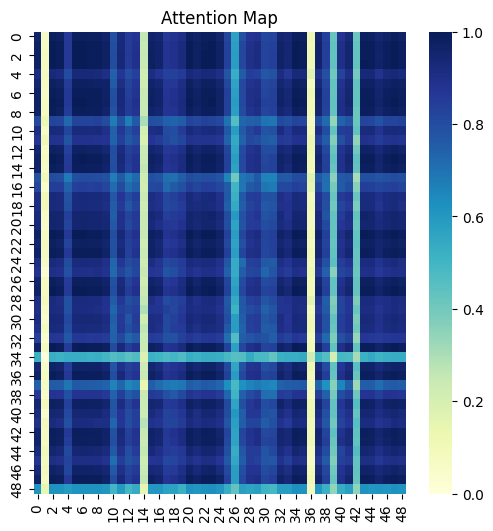

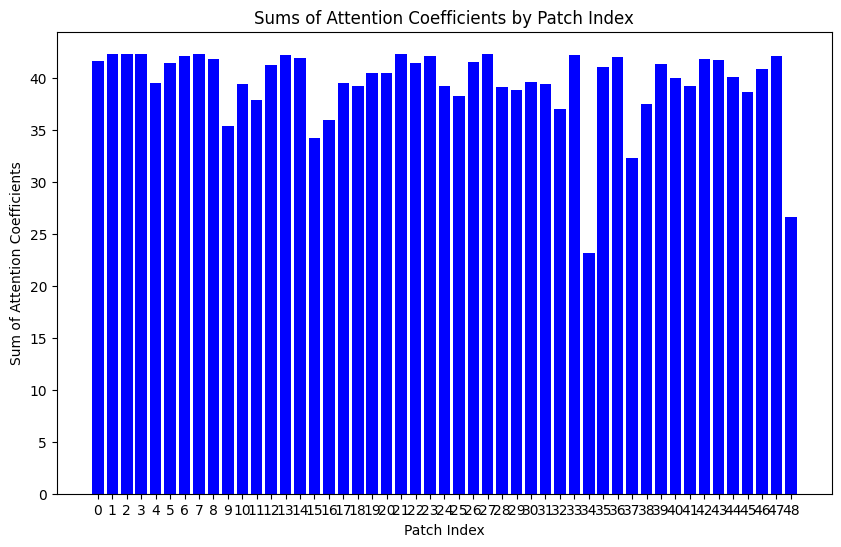

Q_output size: torch.Size([49, 160, 49])
K_output size: torch.Size([49, 160, 49])
V_output size: torch.Size([160, 49, 16])


/tmp/ipykernel_91716/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.5500)

tensor(424.9694, grad_fn=<DivBackward1>)


 10%|█         | 1/10 [10:48<1:37:20, 648.91s/it]

Complete 0 th
torch.Size([160, 49, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9571, 0.6805, 0.9913,  ..., 0.9983, 0.9903, 1.0000],
         [0.9925, 0.5759, 0.9992,  ..., 0.9934, 0.9994, 0.9835],
         [0.9826, 0.6150, 0.9997,  ..., 0.9987, 0.9995, 0.9931],
         ...,
         [0.9500, 0.6949, 0.9878,  ..., 0.9966, 0.9866, 0.9999],
         [0.9730, 0.6432, 0.9975,  ..., 1.0000, 0.9970, 0.9975],
         [0.7551, 0.9140, 0.8424,  ..., 0.8773, 0.8386, 0.9060]],

        [[0.9994, 0.6741, 0.9916,  ..., 0.9884, 0.9946, 0.9993],
         [0.9869, 0.5968, 1.0000,  ..., 0.9614, 0.9997, 0.9959],
         [0.9900, 0.6090, 0.9998,  ..., 0.9667, 1.0000, 0.9976],
         ...,
         [0.9844, 0.5875, 0.9999,  ..., 0.9572, 0.9992, 0.9945],
         [0.9730, 0.5534, 0.9975,  ..., 0.9398, 0.9955, 0.9870],
         [0.7551, 0.2765, 0.8424,  ..., 0.6862, 0.8297, 0.7949]],

        [[0.9997, 0.5167, 0.9913,  ..., 0.9795, 0.9926, 0.9993],
         [0.9874, 0.5968, 1.0000,  ..., 0.9975, 0.9999, 0.9955],
         [0.9841, 0.6090, 0.9998,  ..., 0.9987, 0.9

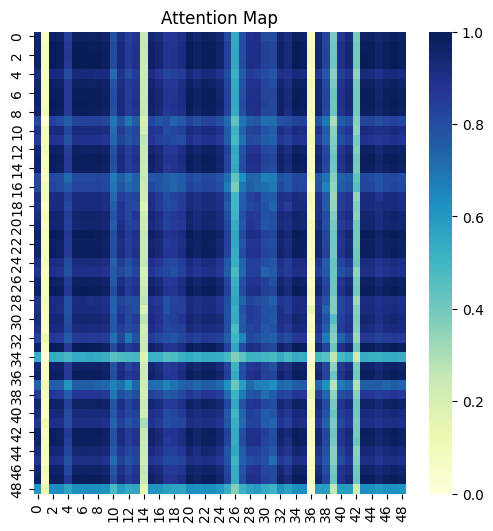

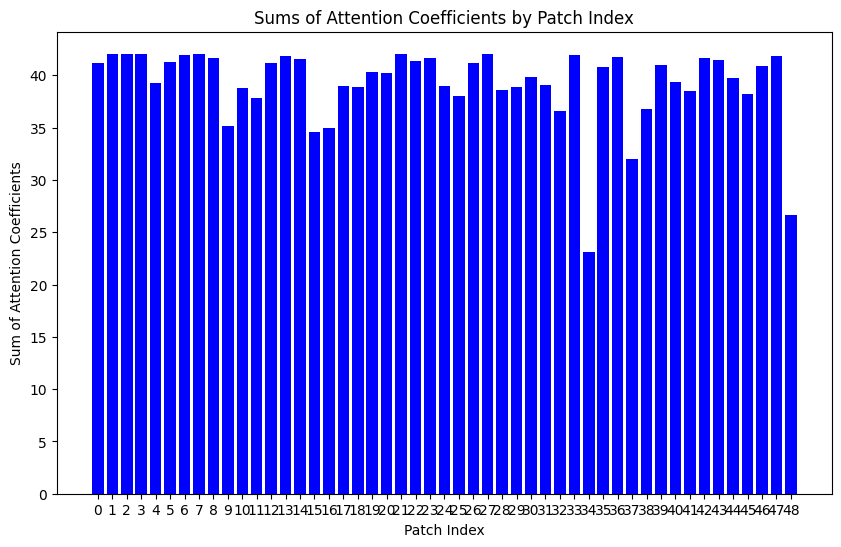

Q_output size: torch.Size([49, 160, 49])
K_output size: torch.Size([49, 160, 49])
V_output size: torch.Size([160, 49, 16])


/tmp/ipykernel_91716/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.7937)

tensor(418.3212, grad_fn=<DivBackward1>)


 20%|██        | 2/10 [21:59<1:28:12, 661.52s/it]

Complete 1 th
torch.Size([160, 49, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9561, 0.6792, 0.9918,  ..., 0.9993, 0.9909, 0.9999],
         [0.9848, 0.6040, 1.0000,  ..., 0.9962, 0.9999, 0.9907],
         [0.9811, 0.6163, 0.9997,  ..., 0.9978, 0.9995, 0.9932],
         ...,
         [0.9492, 0.6930, 0.9886,  ..., 0.9981, 0.9876, 0.9999],
         [0.9719, 0.6425, 0.9977,  ..., 0.9997, 0.9973, 0.9973],
         [0.7591, 0.9090, 0.8495,  ..., 0.8910, 0.8463, 0.9115]],

        [[0.9561, 0.5259, 0.9921,  ..., 0.8709, 0.9929, 0.9772],
         [0.9856, 0.6040, 1.0000,  ..., 0.9245, 0.9999, 0.9964],
         [0.9811, 0.5887, 0.9998,  ..., 0.9150, 0.9999, 0.9939],
         ...,
         [0.9823, 0.5925, 0.9999,  ..., 0.9174, 1.0000, 0.9946],
         [0.9719, 0.5625, 0.9979,  ..., 0.8976, 0.9983, 0.9882],
         [0.7591, 0.2887, 0.8509,  ..., 0.6257, 0.8541, 0.8056]],

        [[0.9990, 0.5259, 0.9922,  ..., 0.9795, 0.9909, 0.9992],
         [0.9918, 0.5758, 0.9991,  ..., 0.9927, 0.9986, 0.9990],
         [0.9888, 0.5887, 0.9998,  ..., 0.9951, 0.9

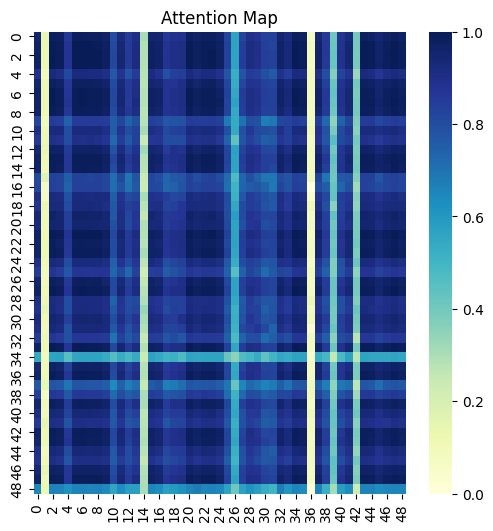

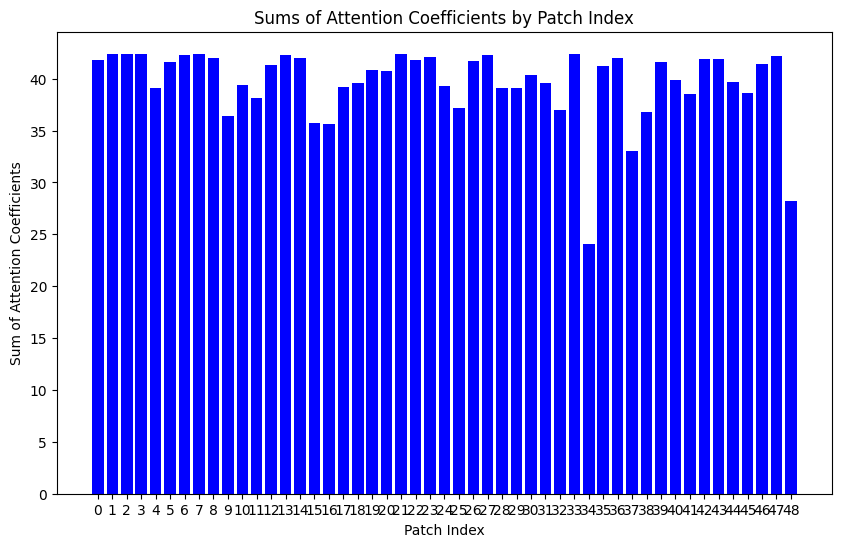

Q_output size: torch.Size([49, 160, 49])
K_output size: torch.Size([49, 160, 49])
V_output size: torch.Size([160, 49, 16])


/tmp/ipykernel_91716/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9250)

tensor(413.6246, grad_fn=<DivBackward1>)


 30%|███       | 3/10 [33:26<1:18:33, 673.30s/it]

Complete 2 th
torch.Size([160, 49, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9571, 0.6801, 0.9926,  ..., 0.9990, 0.9948, 0.9999],
         [0.9772, 0.6310, 0.9992,  ..., 0.9993, 0.9998, 0.9956],
         [0.9862, 0.6018, 1.0000,  ..., 0.9964, 0.9996, 0.9900],
         ...,
         [0.9995, 0.5201, 0.9897,  ..., 0.9760, 0.9867, 0.9622],
         [0.9729, 0.6428, 0.9982,  ..., 0.9999, 0.9992, 0.9972],
         [0.9294, 0.2975, 0.8561,  ..., 0.8179, 0.8466, 0.7875]],

        [[0.9984, 0.6732, 0.9927,  ..., 0.9649, 0.9914, 0.9999],
         [0.9904, 0.6240, 0.9992,  ..., 0.9410, 0.9988, 0.9956],
         [0.9874, 0.6116, 0.9998,  ..., 0.9341, 0.9996, 0.9935],
         ...,
         [0.9957, 0.7608, 0.9639,  ..., 0.9932, 0.9612, 0.9905],
         [0.9711, 0.5612, 0.9980,  ..., 0.9028, 0.9985, 0.9807],
         [0.7627, 0.2922, 0.8559,  ..., 0.6392, 0.8606, 0.7875]],

        [[0.9984, 0.6732, 0.9927,  ..., 0.9990, 0.9948, 0.9669],
         [0.9836, 0.5978, 1.0000,  ..., 0.9968, 0.9997, 0.9910],
         [0.9874, 0.6116, 0.9998,  ..., 0.9984, 1.0

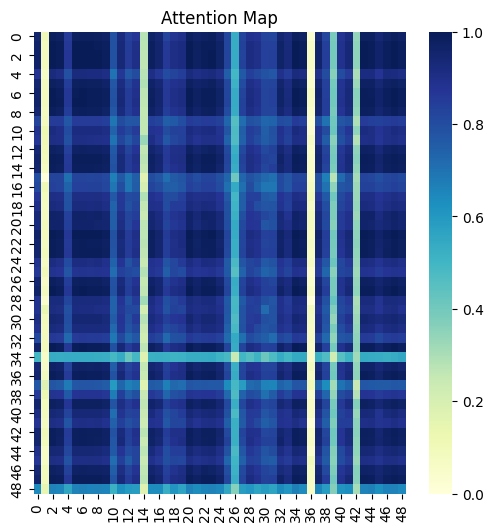

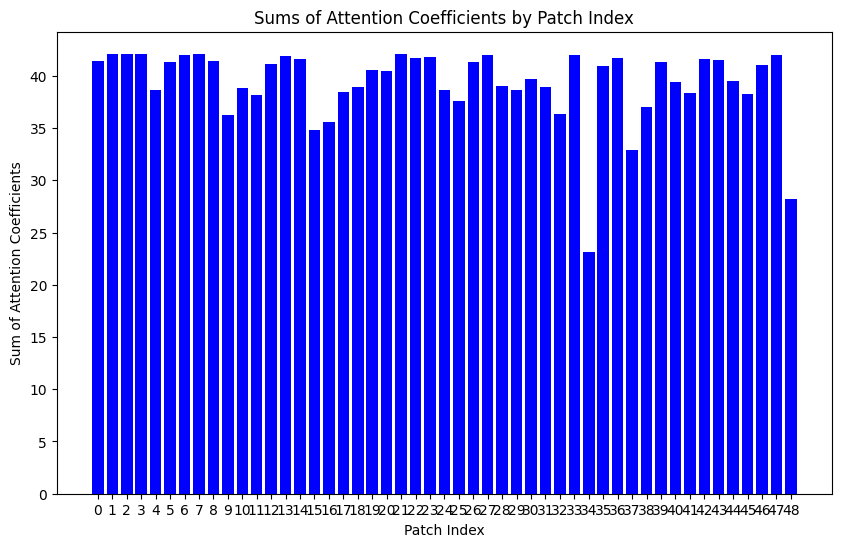

Q_output size: torch.Size([49, 160, 49])
K_output size: torch.Size([49, 160, 49])
V_output size: torch.Size([160, 49, 16])


/tmp/ipykernel_91716/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9812)

tensor(409.8618, grad_fn=<DivBackward1>)


 40%|████      | 4/10 [45:13<1:08:38, 686.45s/it]

Complete 3 th
torch.Size([160, 49, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9528, 0.5272, 0.9923,  ..., 0.9997, 0.9949, 0.9990],
         [0.9742, 0.5768, 0.9991,  ..., 0.9984, 0.9998, 0.9993],
         [0.9833, 0.6040, 1.0000,  ..., 0.9949, 0.9997, 0.9965],
         ...,
         [0.9462, 0.5144, 0.9894,  ..., 0.9989, 0.9925, 0.9978],
         [0.9694, 0.5642, 0.9980,  ..., 0.9994, 0.9992, 0.9998],
         [0.9326, 0.9049, 0.8549,  ..., 0.8052, 0.8437, 0.8147]],

        [[0.9552, 0.5272, 0.9923,  ..., 0.8711, 0.9917, 0.9999],
         [0.9900, 0.6242, 0.9993,  ..., 0.9356, 0.9995, 0.9855],
         [0.9871, 0.6125, 0.9999,  ..., 0.9289, 0.9999, 0.9886],
         ...,
         [0.9811, 0.5918, 0.9999,  ..., 0.9163, 0.9998, 0.9931],
         [0.9713, 0.5641, 0.9980,  ..., 0.8980, 0.9977, 0.9974],
         [0.9376, 0.8955, 0.8656,  ..., 0.9908, 0.8679, 0.7980]],

        [[0.9552, 0.5208, 0.9923,  ..., 0.9992, 0.9917, 0.9990],
         [0.9760, 0.5702, 0.9991,  ..., 0.9991, 0.9989, 0.9993],
         [0.9800, 0.5819, 0.9997,  ..., 0.9981, 0.9

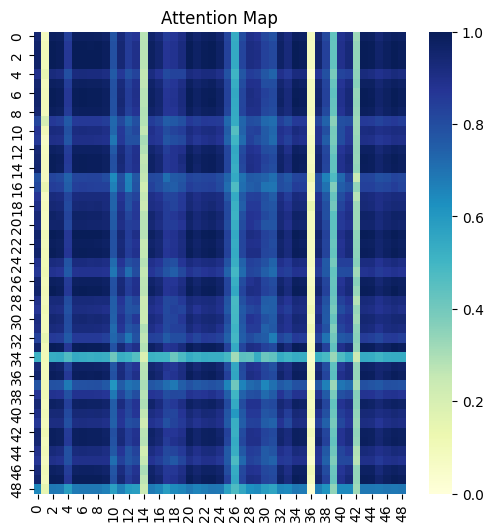

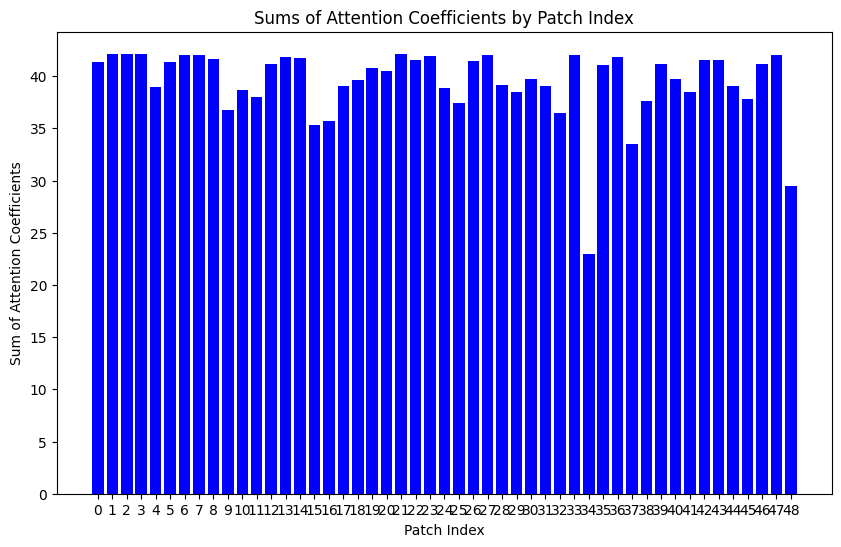

Q_output size: torch.Size([49, 160, 49])
K_output size: torch.Size([49, 160, 49])
V_output size: torch.Size([160, 49, 16])


/tmp/ipykernel_91716/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9812)

tensor(407.1958, grad_fn=<DivBackward1>)


 50%|█████     | 5/10 [57:55<59:29, 713.81s/it]  

Complete 4 th
torch.Size([160, 49, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9541, 0.5255, 0.9930,  ..., 0.9994, 0.9916, 0.9814],
         [0.9893, 0.6219, 0.9992,  ..., 0.9924, 0.9995, 0.9994],
         [0.9841, 0.6023, 1.0000,  ..., 0.9958, 1.0000, 0.9978],
         ...,
         [0.9988, 0.6812, 0.9903,  ..., 0.9756, 0.9918, 0.9979],
         [0.9704, 0.5622, 0.9984,  ..., 0.9997, 0.9977, 0.9912],
         [0.7674, 0.2982, 0.8644,  ..., 0.9008, 0.8593, 0.8276]],

        [[0.9976, 0.6731, 0.9928,  ..., 0.6367, 0.9914, 1.0000],
         [0.9812, 0.5976, 1.0000,  ..., 0.7113, 1.0000, 0.9917],
         [0.9777, 0.5868, 0.9997,  ..., 0.7217, 0.9999, 0.9892],
         ...,
         [0.9879, 0.6211, 0.9994,  ..., 0.6884, 0.9990, 0.9959],
         [0.9912, 0.6352, 0.9984,  ..., 0.6745, 0.9977, 0.9977],
         [0.9407, 0.8953, 0.8644,  ..., 0.3913, 0.8593, 0.9175]],

        [[0.9541, 0.6721, 0.9923,  ..., 0.9759, 0.9916, 0.9694],
         [0.9754, 0.6219, 0.9992,  ..., 0.9906, 0.9989, 0.9863],
         [0.9793, 0.6105, 0.9997,  ..., 0.9930, 0.9

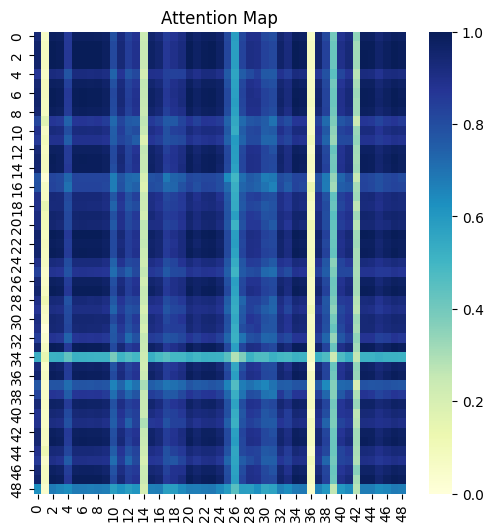

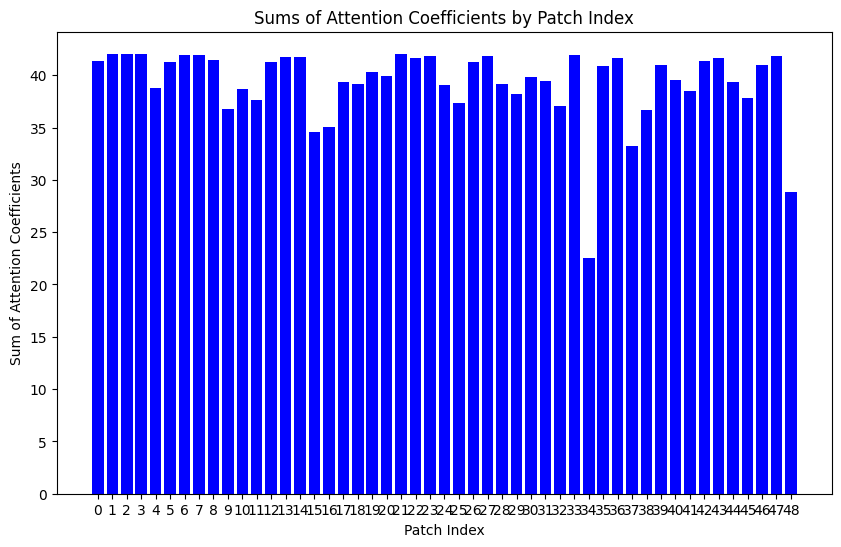

Q_output size: torch.Size([49, 160, 49])
K_output size: torch.Size([49, 160, 49])
V_output size: torch.Size([160, 49, 16])


/tmp/ipykernel_91716/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9812)

tensor(405.2975, grad_fn=<DivBackward1>)


 60%|██████    | 6/10 [1:09:39<47:22, 710.58s/it]

Complete 5 th
torch.Size([160, 49, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9977, 0.5258, 0.9920,  ..., 0.9778, 0.9913, 0.9984],
         [0.9882, 0.5772, 0.9991,  ..., 0.9921, 0.9989, 0.9996],
         [0.9777, 0.6125, 0.9999,  ..., 0.9977, 0.9999, 0.9962],
         ...,
         [0.9473, 0.6829, 0.9912,  ..., 0.9988, 0.9918, 0.9794],
         [0.9681, 0.6383, 0.9983,  ..., 0.9997, 0.9985, 0.9916],
         [0.9320, 0.2881, 0.8496,  ..., 0.8067, 0.8472, 0.8825]],

        [[0.9506, 0.6764, 0.9925,  ..., 0.8052, 0.9943, 0.9983],
         [0.9821, 0.5989, 1.0000,  ..., 0.8690, 0.9998, 0.9976],
         [0.9829, 0.5965, 1.0000,  ..., 0.8708, 0.9997, 0.9973],
         ...,
         [0.9790, 0.6088, 0.9999,  ..., 0.8614, 1.0000, 0.9986],
         [0.9916, 0.5624, 0.9978,  ..., 0.8955, 0.9967, 0.9916],
         [0.9393, 0.2979, 0.8598,  ..., 0.9999, 0.8523, 0.8285]],

        [[0.9529, 0.5175, 0.9916,  ..., 0.9997, 0.9943, 0.9815],
         [0.9827, 0.5919, 1.0000,  ..., 0.9950, 0.9999, 0.9976],
         [0.9819, 0.5895, 1.0000,  ..., 0.9954, 0.9

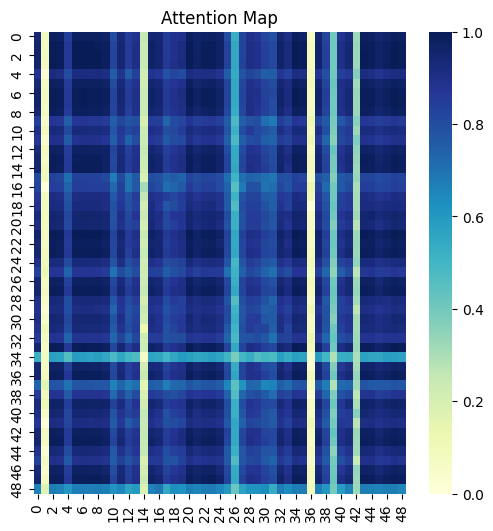

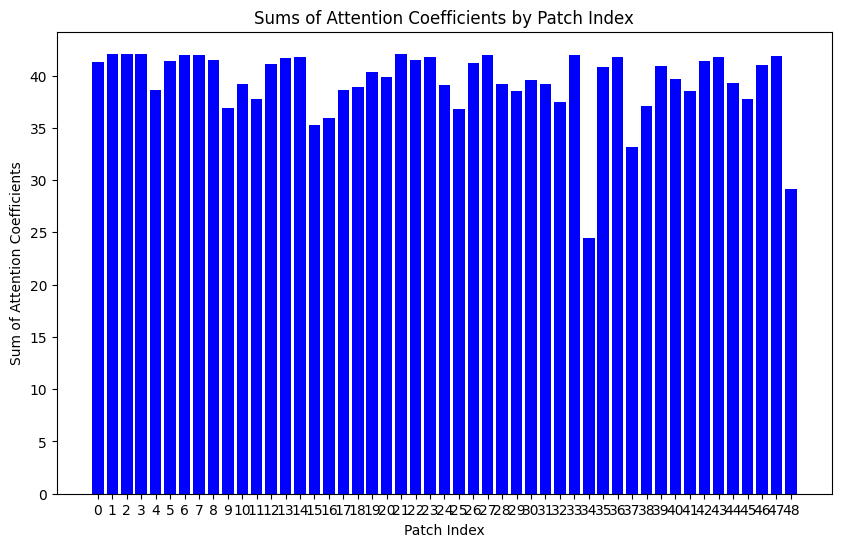

Q_output size: torch.Size([49, 160, 49])
K_output size: torch.Size([49, 160, 49])
V_output size: torch.Size([160, 49, 16])


/tmp/ipykernel_91716/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9875)

tensor(403.4943, grad_fn=<DivBackward1>)


 70%|███████   | 7/10 [1:22:11<36:11, 723.93s/it]

Complete 6 th
torch.Size([160, 49, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9985, 0.5261, 0.9923,  ..., 0.9762, 0.9906, 0.9700],
         [0.9757, 0.6267, 0.9991,  ..., 0.9986, 0.9996, 0.9968],
         [0.9823, 0.6067, 1.0000,  ..., 0.9963, 1.0000, 0.9936],
         ...,
         [0.9986, 0.5252, 0.9921,  ..., 0.9758, 0.9904, 0.9697],
         [0.9700, 0.6417, 0.9977,  ..., 0.9996, 0.9985, 0.9985],
         [0.9344, 0.2976, 0.8607,  ..., 0.8132, 0.8545, 0.7989]],

        [[0.9505, 0.6730, 0.9914,  ..., 0.9230, 0.9906, 0.9819],
         [0.9813, 0.5979, 1.0000,  ..., 0.8715, 0.9999, 0.9978],
         [0.9781, 0.6076, 0.9997,  ..., 0.8787, 0.9996, 0.9966],
         ...,
         [0.9795, 0.6034, 0.9999,  ..., 0.8757, 0.9998, 0.9971],
         [0.9920, 0.5572, 0.9982,  ..., 0.8394, 0.9985, 1.0000],
         [0.7476, 0.9054, 0.8473,  ..., 0.9990, 0.8445, 0.8174]],

        [[0.9979, 0.5278, 0.9926,  ..., 0.9998, 0.9897, 1.0000],
         [0.9741, 0.6267, 0.9991,  ..., 0.9897, 0.9998, 0.9877],
         [0.9781, 0.6152, 0.9997,  ..., 0.9922, 1.0

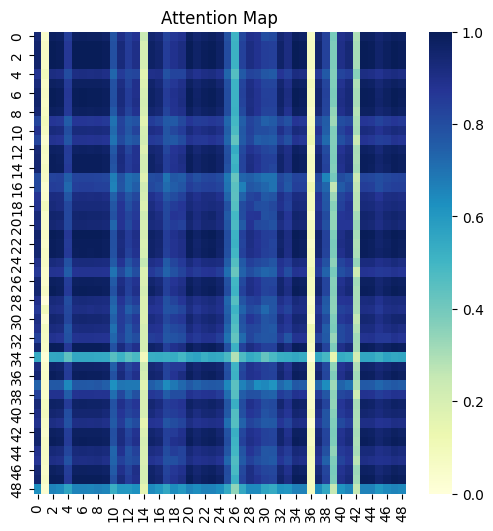

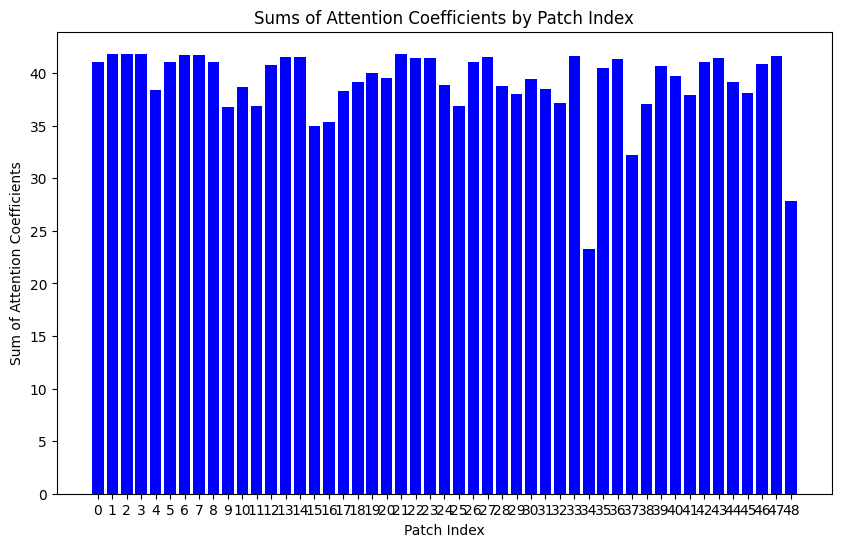

Q_output size: torch.Size([49, 160, 49])
K_output size: torch.Size([49, 160, 49])
V_output size: torch.Size([160, 49, 16])


/tmp/ipykernel_91716/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9875)

tensor(402.3463, grad_fn=<DivBackward1>)


 80%|████████  | 8/10 [1:35:35<24:59, 749.62s/it]

Complete 7 th
torch.Size([160, 49, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9519, 0.6839, 0.9915,  ..., 0.9725, 0.9941, 0.9830],
         [0.9746, 0.6314, 0.9990,  ..., 0.9890, 0.9998, 0.9952],
         [0.9817, 0.6104, 1.0000,  ..., 0.9935, 0.9999, 0.9980],
         ...,
         [0.9524, 0.6828, 0.9917,  ..., 0.9729, 0.9943, 0.9834],
         [0.9687, 0.6467, 0.9976,  ..., 0.9850, 0.9989, 0.9925],
         [0.9264, 0.2885, 0.8480,  ..., 0.8959, 0.8370, 0.8735]],

        [[0.9509, 0.6774, 0.9911,  ..., 0.8143, 0.9938, 0.9707],
         [0.9746, 0.6230, 0.9990,  ..., 0.8593, 0.9998, 0.9882],
         [0.9859, 0.5875, 0.9999,  ..., 0.8859, 0.9993, 0.9955],
         ...,
         [0.9973, 0.5303, 0.9940,  ..., 0.9242, 0.9913, 1.0000],
         [0.9925, 0.5596, 0.9982,  ..., 0.9053, 0.9965, 0.9988],
         [0.9334, 0.2911, 0.8575,  ..., 0.9989, 0.8467, 0.9059]],

        [[0.9986, 0.5308, 0.9915,  ..., 0.9725, 0.9941, 0.9999],
         [0.9902, 0.5833, 0.9990,  ..., 0.9890, 0.9998, 0.9972],
         [0.9871, 0.5960, 0.9997,  ..., 0.9918, 1.0

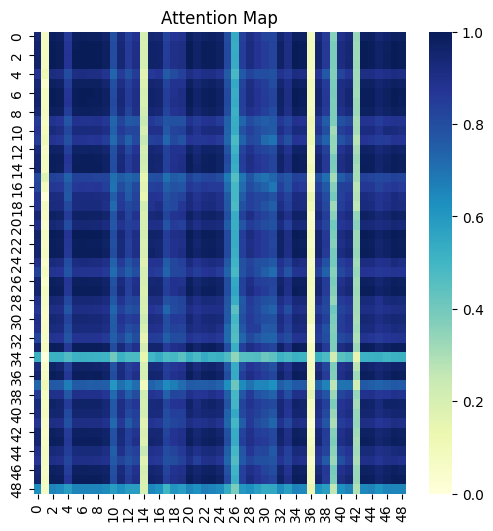

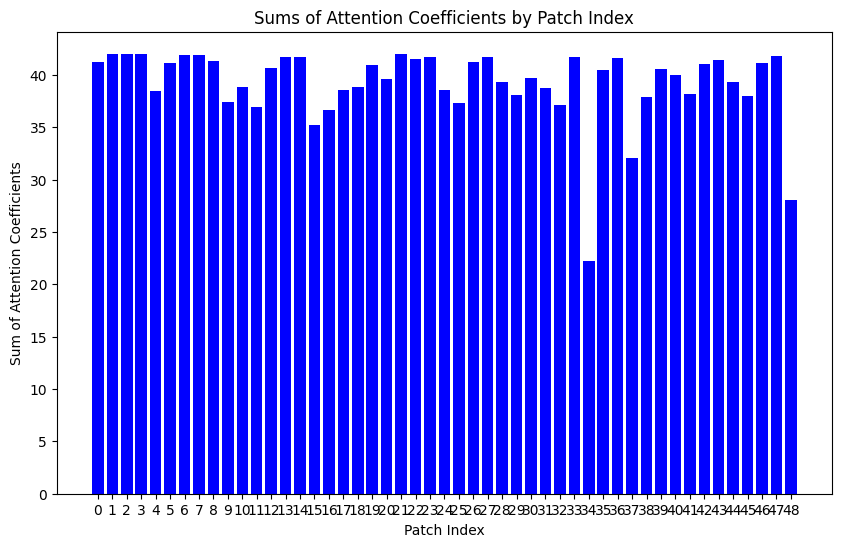

Q_output size: torch.Size([49, 160, 49])
K_output size: torch.Size([49, 160, 49])
V_output size: torch.Size([160, 49, 16])


/tmp/ipykernel_91716/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9937)

tensor(401.3730, grad_fn=<DivBackward1>)


 90%|█████████ | 9/10 [1:48:21<12:34, 754.60s/it]

Complete 8 th
torch.Size([160, 49, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9984, 0.6887, 0.9924,  ..., 0.9741, 0.9939, 0.9834],
         [0.9840, 0.6144, 1.0000,  ..., 0.9944, 0.9999, 0.9982],
         [0.9863, 0.6225, 0.9999,  ..., 0.9930, 1.0000, 0.9974],
         ...,
         [0.9979, 0.6833, 0.9934,  ..., 0.9761, 0.9949, 0.9850],
         [0.9688, 0.5706, 0.9974,  ..., 0.9994, 0.9964, 0.9999],
         [0.9301, 0.9131, 0.8544,  ..., 0.8011, 0.8607, 0.8252]],

        [[0.9986, 0.6866, 0.9917,  ..., 0.9490, 0.9943, 0.9975],
         [0.9852, 0.6144, 1.0000,  ..., 0.9794, 0.9999, 0.9988],
         [0.9810, 0.6002, 0.9999,  ..., 0.9839, 0.9993, 0.9974],
         ...,
         [0.9809, 0.8261, 0.9309,  ..., 0.8487, 0.9385, 0.9502],
         [0.9939, 0.6520, 0.9974,  ..., 0.9653, 0.9988, 0.9999],
         [0.9275, 0.9131, 0.8500,  ..., 0.7467, 0.8607, 0.8775]],

        [[0.9552, 0.5269, 0.9917,  ..., 0.9722, 0.9910, 0.9727],
         [0.9905, 0.6262, 0.9994,  ..., 0.9973, 0.9995, 0.9975],
         [0.9874, 0.6133, 0.9999,  ..., 0.9956, 1.0

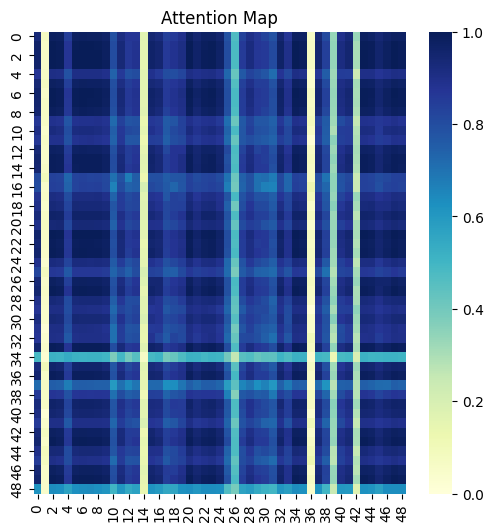

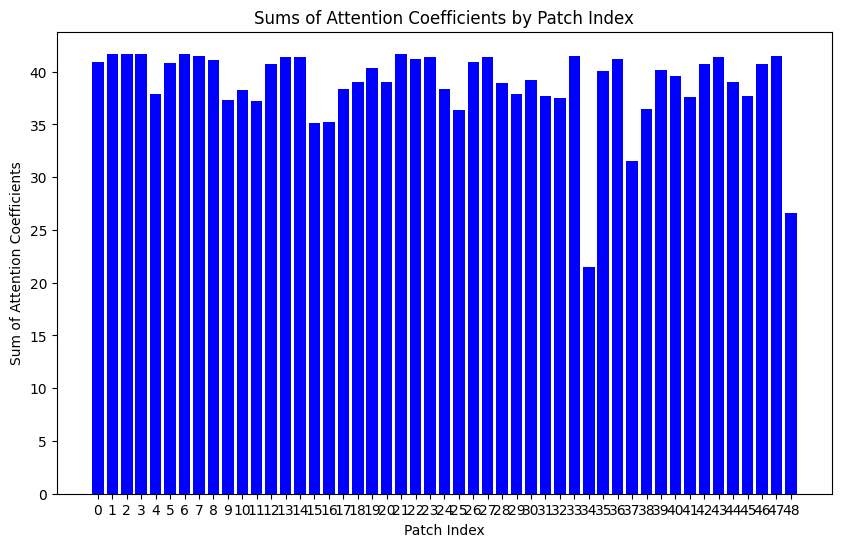

Q_output size: torch.Size([49, 160, 49])
K_output size: torch.Size([49, 160, 49])
V_output size: torch.Size([160, 49, 16])


/tmp/ipykernel_91716/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2



Accuracy: tensor(0.9937)

tensor(400.6546, grad_fn=<DivBackward1>)


100%|██████████| 10/10 [1:59:44<00:00, 718.46s/it]

Complete 9 th


In [46]:
for iepoch in tqdm(range(10)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    for i in range(len(label)):
        if label[i]==1:
            label[i] = 0
        else:
            label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = binary_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()
    print("Complete "+str(iepoch)+" th")

torch.Size([40, 49, 16])


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9986, 0.6897, 0.9929,  ..., 0.9741, 0.9935, 0.9736],
         [0.9772, 0.5915, 0.9990,  ..., 0.9978, 0.9988, 0.9977],
         [0.9854, 0.6179, 1.0000,  ..., 0.9940, 1.0000, 0.9938],
         ...,
         [0.9982, 0.6850, 0.9938,  ..., 0.9758, 0.9943, 0.9754],
         [0.9942, 0.6564, 0.9980,  ..., 0.9851, 0.9983, 0.9847],
         [0.9244, 0.9181, 0.8512,  ..., 0.7948, 0.8534, 0.7937]],

        [[0.9985, 0.6825, 0.9924,  ..., 0.9998, 0.9930, 0.9971],
         [0.9844, 0.6084, 1.0000,  ..., 0.9950, 1.0000, 0.9989],
         [0.9801, 0.5945, 0.9997,  ..., 0.9924, 0.9996, 0.9976],
         ...,
         [0.9572, 0.5369, 0.9931,  ..., 0.9763, 0.9925, 0.9864],
         [0.9935, 0.6466, 0.9980,  ..., 0.9993, 0.9983, 0.9999],
         [0.9199, 0.9191, 0.8420,  ..., 0.8888, 0.8442, 0.8647]],

        [[0.9550, 0.6922, 0.9913,  ..., 0.9999, 0.9939, 0.9840],
         [0.9907, 0.5915, 0.9994,  ..., 0.9879, 0.9984, 0.9999],
         [0.9839, 0.6179, 1.0000,  ..., 0.9937, 0.9

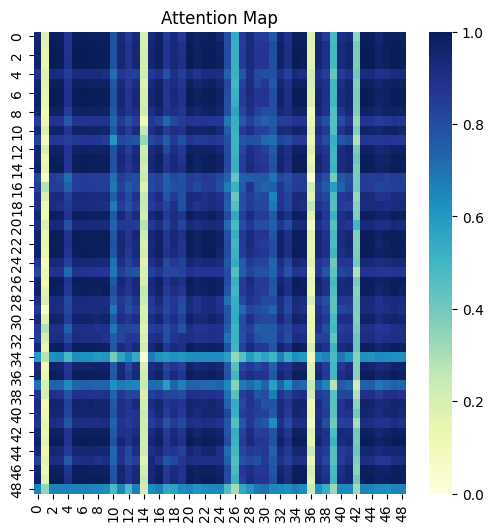

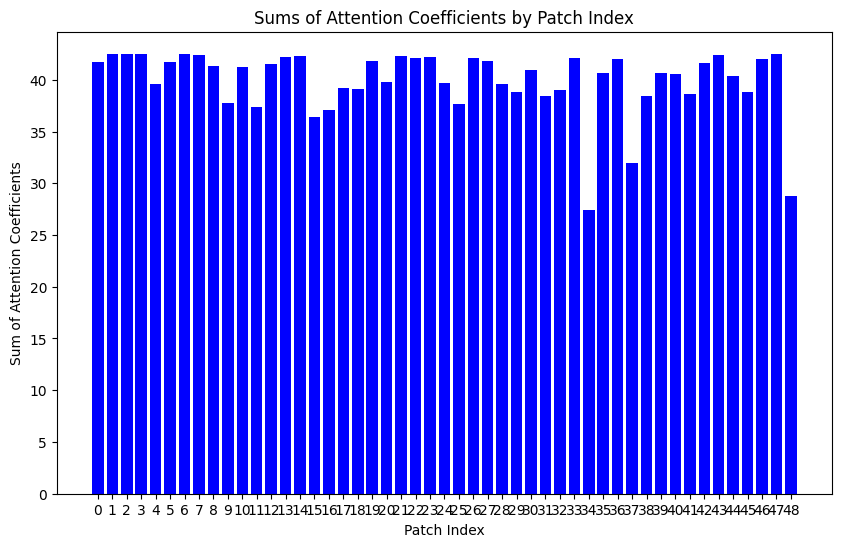

Q_output size: torch.Size([49, 40, 49])
K_output size: torch.Size([49, 40, 49])
V_output size: torch.Size([40, 49, 16])

Accuracy: 0.9750000238418579

Loss: 48.5924186706543

AUROC: 1.0



/tmp/ipykernel_91716/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [47]:
from sklearn.metrics import roc_auc_score

X_tensor=torch.tensor(X_test)
predictions=model(X_tensor.float()).squeeze(1)
label=torch.tensor(y_test)
for i in range(len(label)):
        if label[i]==1:
            label[i] = 0
        else:
            label[i]=1
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Calculate AUROC
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy
auroc = roc_auc_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')

-----------------------------------------